In [2]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
import splitfolders
import visualkeras

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.0


In [3]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [4]:
%cd /Users/irfanmasudi/ANNDL/Challenge/

/Users/irfanmasudi/ANNDL/Challenge


In [5]:
# Dataset folders 
dataset_dir = 'datasets'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
#test_dir = os.path.join(dataset_dir, 'test')

In [18]:
# Plot example images from dataset
labels = ['Apple',       # 0
          'Blueberry',   # 1
          'Cherry',      # 2
          'Corn',        # 3
          'Grape',       # 4
          'Orange',      # 5
          'Peach',       # 6
          'Pepper',      # 7
          'Potato',      # 8
          'Raspberry',   # 9
          'Soybean',     # 10
          'Squash',      # 11
          'Strawberry',  # 12
          'Tomato']   

In [19]:
incresnet = tf.keras.applications.InceptionResNetV2(
    include_top=False,
    weights='imagenet'
)

In [41]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Creating an instance of ImageDataGenerator without Data Augmentation
noaug_train_data_gen = ImageDataGenerator(preprocessing_function=tfk.applications.inception_resnet_v2.preprocess_input)
valid_data_gen       = ImageDataGenerator(preprocessing_function=tfk.applications.inception_resnet_v2.preprocess_input)

train_gen = noaug_train_data_gen.flow_from_directory(directory=training_dir,
                                                           target_size=(299,299),
                                                           color_mode='rgb',
                                                           classes=None,
                                                           class_mode='categorical',
                                                           batch_size=64,
                                                           shuffle=True,
                                                           seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(299,299),
                                               color_mode='rgb',
                                               classes=None,
                                               class_mode='categorical',
                                               batch_size=64,
                                               shuffle=False, # no need to shuffle validation set
                                               seed=seed)

Found 67279 images belonging to 14 classes.
Found 3552 images belonging to 14 classes.


In [42]:
def get_next_batch(generator):
    batch = next(generator)

    image = batch[0]
    target = batch[1]

    print("(Input) image shape:", image.shape)
    print("Target shape:",target.shape)

    # Visualize only the first sample
    image = image[0]
    target = target[0]
    target_idx = np.argmax(target)
    print()
    print("Categorical label:", target)
    print("Label:", target_idx)
    print("Class name:", labels[target_idx])
    
    fig = plt.figure(figsize=(6, 4))
    plt.imshow(np.uint8(image))
    plt.show()
    
    return batch

(Input) image shape: (64, 299, 299, 3)
Target shape: (64, 14)

Categorical label: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Label: 7
Class name: Pepper


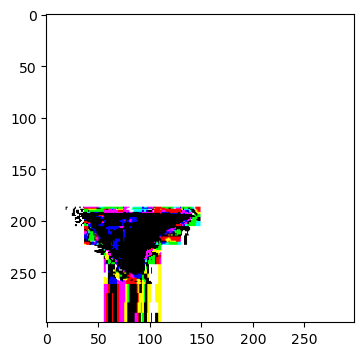

In [43]:
# Get a sample from dataset and show info
_ = get_next_batch(train_gen)

In [44]:
METRICS = [
      tfk.metrics.TruePositives(name='tp'),
      tfk.metrics.FalsePositives(name='fp'),
      tfk.metrics.TrueNegatives(name='tn'),
      tfk.metrics.FalseNegatives(name='fn'), 
      tfk.metrics.BinaryAccuracy(name='accuracy'),
      tfk.metrics.Precision(name='precision'),
      tfk.metrics.Recall(name='recall'),
      tfk.metrics.AUC(name='auc'),
]

In [45]:
incresnet.trainable = False

inputs = tfk.Input(shape=(299,299,3))

model = incresnet(inputs)

# Rebuild top
x = tfkl.GlobalAveragePooling2D(name="avg_pool")(model)

#x = tfkl.BatchNormalization()(x)

x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)

#x = tfkl.BatchNormalization()(x)

x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)

#x = tfkl.BatchNormalization()(x)

x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)

#x = tfkl.BatchNormalization()(x)

x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)

#x = tfkl.BatchNormalization()(x)

x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)

#x = tfkl.BatchNormalization()(x)

x = tfkl.Dropout(0.3, seed=seed)(x)
outputs = tfkl.Dense(
    14, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)

tl_model = tfk.Model(inputs=inputs, outputs=outputs, name="IncResnet")
optimizer = tfk.optimizers.Adam()
tl_model.compile(
    optimizer=optimizer, loss=tfk.losses.CategoricalCrossentropy(), metrics=METRICS
)


In [46]:
# Freeze first N layers, e.g., until 14th
for i, layer in enumerate(tl_model.get_layer('inception_resnet_v2').layers[-14:]):
    #if not isinstance(layer, tfkl.BatchNormalization):
    layer.trainable = True
for i, layer in enumerate(tl_model.get_layer('inception_resnet_v2').layers):
    print(i, layer.name, layer.trainable)
tl_model.summary()

0 input_2 False
1 conv2d_203 False
2 batch_normalization_203 False
3 activation_203 False
4 conv2d_204 False
5 batch_normalization_204 False
6 activation_204 False
7 conv2d_205 False
8 batch_normalization_205 False
9 activation_205 False
10 max_pooling2d_4 False
11 conv2d_206 False
12 batch_normalization_206 False
13 activation_206 False
14 conv2d_207 False
15 batch_normalization_207 False
16 activation_207 False
17 max_pooling2d_5 False
18 conv2d_211 False
19 batch_normalization_211 False
20 activation_211 False
21 conv2d_209 False
22 conv2d_212 False
23 batch_normalization_209 False
24 batch_normalization_212 False
25 activation_209 False
26 activation_212 False
27 average_pooling2d_1 False
28 conv2d_208 False
29 conv2d_210 False
30 conv2d_213 False
31 conv2d_214 False
32 batch_normalization_208 False
33 batch_normalization_210 False
34 batch_normalization_213 False
35 batch_normalization_214 False
36 activation_208 False
37 activation_210 False
38 activation_213 False
39 activation_

In [47]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):
    exps_dir = os.path.join('logs/incresnet')
    if not os.path.exists(exps_dir):
        os.makedirs(exps_dir)

    now = datetime.now().strftime('%b%d_%H-%M-%S')

    exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
    if not os.path.exists(exp_dir):
        os.makedirs(exp_dir)
      
    callbacks = []

  # Model checkpoint
  # ----------------
    ckpt_dir = os.path.join(exp_dir, 'ckpts')
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
    callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
    tb_dir = os.path.join(exp_dir, 'tb_logs')
    if not os.path.exists(tb_dir):
        os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
    callbacks.append(tb_callback)

  # Early Stopping
  # --------------
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_auc',
                                                   patience=5, 
                                                   mode = "max",
                                                   verbose=0,
                                                   restore_best_weights=True)
    callbacks.append(es_callback)

    return callbacks

In [48]:
tf.get_logger().setLevel('WARNING') #
tf.get_logger().setLevel('ERROR') # 

# Create folders and callbacks and fit
train_callbacks = create_folders_and_callbacks(model_name='incresnet')

# Train the model
tl_history = tl_model.fit(
    x = train_gen,
    epochs = 200,
    validation_data = valid_gen,
    callbacks = train_callbacks
).history

Epoch 1/200
1052/1052 [==============================] - 2324s 2s/step - loss: 0.8944 - tp: 40944.0000 - fp: 6919.0000 - tn: 867708.0000 - fn: 26335.0000 - accuracy: 0.9647 - precision: 0.8554 - recall: 0.6086 - auc: 0.9655 - val_loss: 0.2433 - val_tp: 3229.0000 - val_fp: 173.0000 - val_tn: 46003.0000 - val_fn: 323.0000 - val_accuracy: 0.9900 - val_precision: 0.9491 - val_recall: 0.9091 - val_auc: 0.9962
Epoch 2/200
1052/1052 [==============================] - 2328s 2s/step - loss: 0.4368 - tp: 56129.0000 - fp: 5469.0000 - tn: 869158.0000 - fn: 11150.0000 - accuracy: 0.9824 - precision: 0.9112 - recall: 0.8343 - auc: 0.9885 - val_loss: 0.2256 - val_tp: 3276.0000 - val_fp: 214.0000 - val_tn: 45962.0000 - val_fn: 276.0000 - val_accuracy: 0.9901 - val_precision: 0.9387 - val_recall: 0.9223 - val_auc: 0.9956
Epoch 3/200
1052/1052 [==============================] - 2267s 2s/step - loss: 0.3509 - tp: 58542.0000 - fp: 4658.0000 - tn: 869969.0000 - fn: 8737.0000 - accuracy: 0.9858 - precision:

In [50]:
# Save best epoch model
tl_model.save("best_model/incresnet")